### TODO: 
* group by time and process at once
* id every separate transport

In [93]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/transport_data.csv')
df.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [3]:
min_t = df['trans_ts'].min()

df['trans_ts'] = df['trans_ts'] - min_t
df['request_ts'] = df['request_ts'] - min_t

#df['day'] = df['trans_ts'] // 86400
df['local_trans_ts'] = df['trans_ts'] % 86400

df.tail()

,log,lat,request_ts,trans_ts,label,local_trans_ts
58660,30.382755,59.942825,345771,345766,?,166
58661,30.306246,59.943558,345801,345782,-,182
58662,30.306704,59.933582,345801,345783,0,183
58663,30.373922,59.937569,345801,345787,-,187
58664,30.336237,59.934052,345801,345795,-,195


In [4]:
df_clean = df[df['label'] != '-']

df_train = df_clean[df_clean['label'] != '?']
df_dev = df_clean[df_clean['label'] == '?']

df_train['label'] = pd.to_numeric(df_train['label'])
df_train.head()

/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,log,lat,request_ts,trans_ts,label,local_trans_ts
0,30.295780,59.932167,233,0,0,0
8,30.385973,59.944260,233,188,0,188
13,30.374880,59.938213,233,208,1,208
17,30.347544,59.932667,233,217,0,217
23,30.312321,59.937405,233,226,2,226


In [5]:
df_mixed = df[df['label'] != '?']

df_mixed['label'] = ['-1' if x=='-' else x for x in df_mixed['label']]
df_mixed['label'] = pd.to_numeric(df_mixed['label'])
df_mixed.head()

/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,log,lat,request_ts,trans_ts,label,local_trans_ts
0,30.295780,59.932167,233,0,0,0
1,30.219528,59.954617,233,152,-1,152
2,30.409101,59.931679,233,153,-1,153
3,30.293602,59.938892,233,165,-1,165
4,30.360102,59.931103,233,173,-1,173


/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


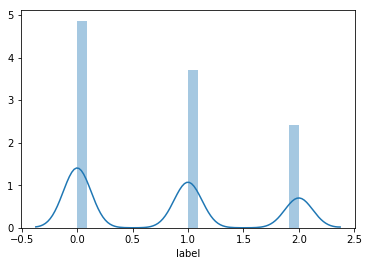

In [15]:
sns.distplot(df_train['label'])

In [245]:
_='''df_d1 = df_train[df_train['day'] == 0]
t = df_d1['request_ts'].unique()
n = len(t)

from matplotlib import animation

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=(59.91, 59.98), ylim=(30.20, 30.50))
ax.set_autoscalex_on(False)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    plt.cla()
    sp0 = ax.scatter(df_d1['lat'].values, df_d1['log'].values, alpha=0.5, c='grey', s=1)
    
    df_t = df_d1[df_d1['request_ts'] == t[i]]
    df_t0 = df_d1[df_d1['request_ts'] == t[i-1]]
    #df_t0 = df_t0[df_t0['request_ts'] > t[ min(0, i-2) ]]
    
    sp1 = ax.scatter(df_t0['lat'].values, df_t0['log'].values, alpha=0.3, c=df_t0['label'].values)
    sp2 = ax.scatter(df_t['lat'].values, df_t['log'].values, c=df_t['label'].values)
    return sp0, sp1, sp2

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=10, blit=False)

anim.save('map.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
plt.show()'''

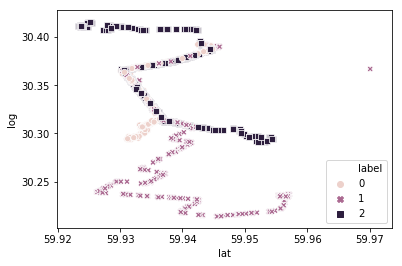

In [47]:
sns.scatterplot(x='lat', y='log', data=df_train, hue="label", style="label")

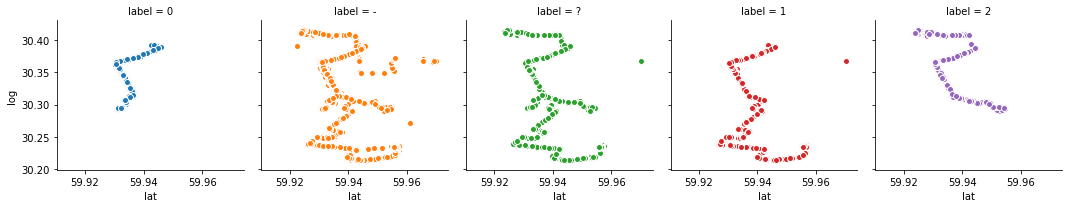

In [76]:
g = sns.FacetGrid(df, col="label", hue="label")
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

In [166]:
y = df_train["label"].values
X = df_train.drop(columns="label").values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(8000, 5) (2000, 5)
8000 2000


In [167]:
'''X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean)/X_std
X_test = (X_test - X_mean)/X_std'''

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

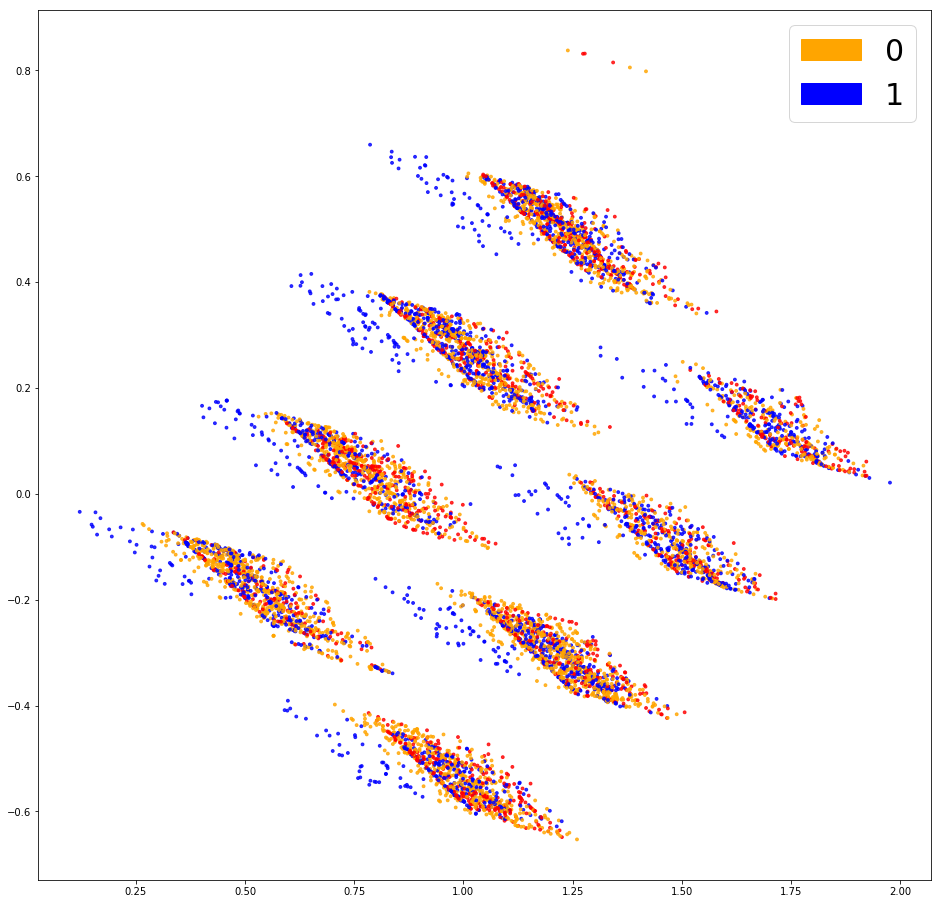

In [26]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            teal_patch = mpatches.Patch(color='teal', label='2')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, y_train)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [170]:
#0.593 w/ 1 local
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.598, precision = 0.595, recall = 0.598, f1 = 0.587


In [122]:
#0.589 w/ 1 local
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.581, precision = 0.581, recall = 0.581, f1 = 0.566


In [125]:
y_prob = 0.35 * rfc.predict_proba(X_test)
y_prob += 0.35 * gbc.predict_proba(X_test)
y_prob += 0.3 * clf.predict_proba(X_test)

y_pred = np.argmax(y_prob, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.593, precision = 0.611, recall = 0.593, f1 = 0.571


In [28]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.536, precision = 0.536, recall = 0.536, f1 = 0.536


In [29]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=40)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.544, precision = 0.630, recall = 0.544, f1 = 0.476


In [124]:
#.550 w/ both locals
clf = MLPClassifier(hidden_layer_sizes=(64, 32, 32, 16), max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.546, precision = 0.640, recall = 0.546, f1 = 0.476


# KFold

In [176]:
from sklearn.model_selection import StratifiedKFold

y = df_train["label"].values
X = df_train.drop(columns="label").values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train_fold, X_dev, y_train_fold, y_dev = train_test_split(X, y, test_size=0.2, shuffle=True)

cv = StratifiedKFold(n_splits=5, shuffle=True)
cv.get_n_splits(X_train_fold, y_train_fold)

5

In [237]:
rfs = []
gbs = []

coefs1 = []
coefs2 = []

for train_index, test_index in cv.split(X_train_fold, y_train_fold):
    X_train, X_test = X_train_fold[train_index], X_train_fold[test_index]
    y_train, y_test = y_train_fold[train_index], y_train_fold[test_index]
    
    rf = RandomForestClassifier(n_estimators=300)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    print("rf - accuracy = %.3f" % (accuracy))
    rfs.append(rf)
    coefs1.append(accuracy)
    
    
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=40)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)   
    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    print("gb - accuracy = %.3f" % (accuracy))
    gbs.append(gb)
    coefs2.append(accuracy)

rf - accuracy = 0.893
gb - accuracy = 0.895
rf - accuracy = 0.899
gb - accuracy = 0.897
rf - accuracy = 0.896
gb - accuracy = 0.899
rf - accuracy = 0.894
gb - accuracy = 0.895
rf - accuracy = 0.890
gb - accuracy = 0.894


In [238]:
n = sum(coefs1) + sum(coefs2)

coefs1 = np.array(coefs1) / n
coefs2 = np.array(coefs2) / n

y_prob = np.zeros((len(y_dev), 3))

for i in range(5):
    y_prob += coefs1[i] * rfs[i].predict_proba(X_dev)
    y_prob += coefs2[i] * gbs[i].predict_proba(X_dev)
    
y_pred = np.argmax(y_prob, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_dev, y_pred)
print("accuracy = %.3f\n" % (accuracy))

accuracy = 0.608



In [242]:
y_prob = np.zeros((len(y_dev), 3))
for i in range(5):
    y_prob += coefs1[i] * rfs[i].predict_proba(X_dev)
    
y_pred = np.argmax(y_prob, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_dev, y_pred)
print("accuracy = %.3f\n" % (accuracy))

accuracy = 0.592



In [240]:
y_prob = np.zeros((len(y_dev), 3))
for i in range(5):
    y_prob += coefs2[i] * gbs[i].predict_proba(X_dev)
    
y_pred = np.argmax(y_prob, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_dev, y_pred)
print("accuracy = %.3f\n" % (accuracy))

accuracy = 0.598



# Pseudolabel

In [188]:
df_unlabeled = df[df['label'] == '-']

X_unlabeled = df_unlabeled.drop(columns="label").values
X_unlabeled = scaler.transform(X_unlabeled)

y_prob = np.zeros((len(X_unlabeled), 3))
for i in range(5):
    y_prob += coefs1[i] * rfs[i].predict_proba(X_unlabeled)
    y_prob += coefs2[i] * gbs[i].predict_proba(X_unlabeled)
    
y_pred = np.argmax(y_prob, axis=1)

In [219]:
X_unlabeled = np.hstack((X_unlabeled, y_pred[:,np.newaxis], y_prob.max(axis=1)[:,np.newaxis]))

columns = ['log', 'lat', 'request_ts', 'trans_ts', 'local_trans_ts', 'label', 'proba']

df_unlabeled = pd.DataFrame(X_unlabeled, columns=columns)

threshold = 0.9
df_unlabeled = df_unlabeled[df_unlabeled['proba'] > threshold]
df_unlabeled.drop(['proba'], axis=1, inplace=True)
df_unlabeled.head()

,log,lat,request_ts,trans_ts,local_trans_ts,label
0,0.028185,0.669628,0.0,0.000440,0.001760,1.0
7,0.110853,0.693912,0.0,0.000547,0.002188,1.0
8,0.407563,0.202999,0.0,0.000547,0.002188,0.0
10,0.445017,0.228099,0.0,0.000604,0.002419,0.0
11,0.134479,0.075625,0.0,0.000610,0.002443,1.0


In [232]:
y_new = df_unlabeled["label"].values
X_new = df_unlabeled.drop(columns="label").values

X_new = scaler.transform(X_new)

X_train_fold = np.vstack((X_train_fold, X_new))
y_train_fold = np.concatenate((y_train_fold, y_new))

In [235]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
cv.get_n_splits(X_train_fold, y_train_fold)

5

# Test

In [253]:
df_test = df[df['label'] == '?']
X_test = df_test.drop(columns="label").values

X_test = scaler.fit_transform(X_test)

y_prob = np.zeros((len(X_test), 3))

for i in range(5):
    y_prob += coefs1[i] * rfs[i].predict_proba(X_test)
    y_prob += coefs2[i] * gbs[i].predict_proba(X_test)
    
y_pred = np.argmax(y_prob, axis=1)

y_pred = [str(x) for x in y_pred]

import os
with open(os.path.join('', 'submission.txt'), 'w') as f:
    f.write('\n'.join(y_pred))

# Semi-supervised

In [ ]:
from sklearn.semi_supervised import LabelPropagation

clf = LabelPropagation(max_iter=1, n_jobs=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [ ]:
from sklearn.semi_supervised import LabelSpreading

clf = LabelSpreading(max_iter=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [98]:
#from sklearn.preprocessing import LabelBinarizer
#enc = LabelBinarizer().fit(y_train)
#y_train_oh = enc.transform(y_train)
#y_test_oh = enc.transform(y_test)

train_x = torch.from_numpy(np.array(X_train, dtype='float32'))
train_y = torch.from_numpy(np.array(y_train, dtype='float32'))
test_x = torch.from_numpy(np.array(X_test, dtype='float32'))
test_y = torch.from_numpy(np.array(y_test, dtype='float32'))

trainset = TensorDataset(train_x, train_y)
testset = TensorDataset(test_x, test_y)

trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
testloader = DataLoader(testset, batch_size=10, shuffle=False)

In [121]:
class Net(nn.Module):
    def __init__(self, n_features=4, n_classes=3):
        super(Net, self).__init__()
        
        self.relu = nn.ReLU()
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, n_classes)
        
    def forward(self, x):
        
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        #x = self.bn3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        #x = self.softmax(x)
        return x

In [122]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

net = Net(n_features=5).to(device)

In [133]:
lr = 1e-4    # -3 --> -5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)

In [124]:
def train(verbose=True):
    net.train()
    running_loss = 0.0
    train_loss = 0.0
    for i, (sample, label) in enumerate(trainloader):
        optimizer.zero_grad()
        
        sample, label = sample.to(device), label.to(device)
        output = net(sample)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loss += loss.item()
        
        if i % 100 == 99:
            #print(' [{} - {}],\ttrain loss: {:.5}'.format(epoch+1, i+1, running_loss/100))
            running_loss = 0.0
    train_loss /= i
    print('[{}], \ttrain loss: {:.5}'.format(epoch+1, train_loss))
    return train_loss

def validate():
    net.eval()
    val_loss = 0.0
    for i, (sample, label) in enumerate(testloader):
        sample, label = sample.to(device), label.to(device)
        with torch.no_grad():
            output = net(sample)
        val_loss += sum(output.argmax(dim=1) == label.long()).item()     #accuracy
    val_loss /= len(testset)
    print(' [{}], \tval loss: {:.5}'.format(epoch+1, val_loss))
    return val_loss

In [138]:
num_epoch = 200
#history = []

for epoch in range(num_epoch):
    train_loss = train()
    val_loss = validate()
    history.append((train_loss, val_loss))
    #scheduler.step(train_loss)

[1], 	train loss: 0.85678
 [1], 	val loss: 0.546
[2], 	train loss: 0.85692
 [2], 	val loss: 0.5465
[3], 	train loss: 0.85688
 [3], 	val loss: 0.5455
[4], 	train loss: 0.8569
 [4], 	val loss: 0.546
[5], 	train loss: 0.85686
 [5], 	val loss: 0.5455
[6], 	train loss: 0.85688
 [6], 	val loss: 0.5465
[7], 	train loss: 0.85689
 [7], 	val loss: 0.546
[8], 	train loss: 0.85684
 [8], 	val loss: 0.5465
[9], 	train loss: 0.85689
 [9], 	val loss: 0.547
[10], 	train loss: 0.85673
 [10], 	val loss: 0.546
[11], 	train loss: 0.8569
 [11], 	val loss: 0.5465
[12], 	train loss: 0.85686
 [12], 	val loss: 0.5465
[13], 	train loss: 0.85683
 [13], 	val loss: 0.5455
[14], 	train loss: 0.85681
 [14], 	val loss: 0.5465
[15], 	train loss: 0.85684
 [15], 	val loss: 0.5465
[16], 	train loss: 0.85685
 [16], 	val loss: 0.5465
[17], 	train loss: 0.85684
 [17], 	val loss: 0.5465
[18], 	train loss: 0.85667
 [18], 	val loss: 0.545
[19], 	train loss: 0.85687
 [19], 	val loss: 0.546
[20], 	train loss: 0.85681
 [20], 	val 

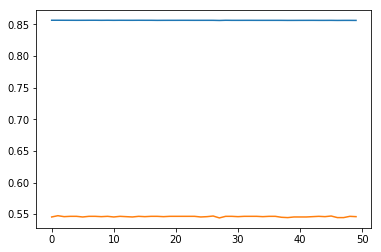

In [297]:
plt.plot(history)

In [ ]:
# 32-16-8 [10] cyclic : 0.861 | 0.553
#                 reg : 0.849 | 0.553

#         [20]        : 0.847 | 0.548
#         [20]    +bn : 0.91  | 0.54

# 64-32-16[10]        : 0.85  | 0.55
#         [20]        : 0.857 | 0.554

# 256-128-64          : 0.847 | 0.551

# 32-16-8 +day        : 0.849 | 0.558